In [42]:
# -*- coding: utf-8 -*-
# 文件名: solve_q1_with_log.py
# 功能: 针对问题一的最终版代码，采用修复式遗传算法，并增加日志输出。
# 版本: Final_Log

import pandas as pd
import numpy as np
import os
import time
import re
import random
import copy
from pathlib import Path
from collections import defaultdict

# --- 1. 模型核心参数配置区 ---
POP_SIZE = 100
MAX_GEN = 200
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# --- 2. 核心功能函数 ---

def load_and_prepare_data(data_path):
    """
    数据加载与处理函数
    """
    try:
        print("（1）正在读取Excel文件...")
        path_f1 = os.path.join(data_path, '附件1.xlsx')
        path_f2 = os.path.join(data_path, '附件2.xlsx')
        
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地')
        crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据')
        past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
        
        for df in [plots_df, crops_info_df, stats_df, past_planting_df]:
            df.columns = df.columns.str.strip()
        
        params = {}
        params['I_plots'] = sorted(plots_df['地块名称'].tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩']))
        params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
        
        params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型']))
        params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
        
        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop = row['种植地块'], row['作物名称']
            season = row.get('种植季节', 1) 
            if plot in params['I_plots']:
                params['P_past'][plot][season] = crop

        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip())
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')

        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price)
        stats_df['亩产量/斤'] = pd.to_numeric(stats_df['亩产量/斤'], errors='coerce')
        stats_df['种植成本/(元/亩)'] = pd.to_numeric(stats_df['种植成本/(元/亩)'], errors='coerce')
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        
        params['P_yield'], params['P_cost'], params['P_price'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型'])
            params['P_cost'][key] = row['种植成本/(元/亩)']
            params['P_yield'][key] = row['亩产量/斤']
            params['P_price'][key] = row['销售单价/(元/斤)']

        for crop in params['J_crops']:
            for plot_type in plots_df['地块类型'].unique():
                key = (crop, plot_type)
                if key not in params['P_yield']:
                    params['P_yield'][key], params['P_cost'][key], params['P_price'][key] = 0, 9e9, 0

        params['P_demand'] = {j: 0 for j in params['J_crops']}
        temp_details = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称')
        for j in params['J_crops']:
            total_yield = sum(
                params['P_yield'].get((j, row['地块类型']), 0) * row.get('种植面积/亩', params['P_area'][row['地块名称']])
                for _, row in temp_details[temp_details['作物名称'] == j].iterrows()
            )
            params['P_demand'][j] = total_yield if total_yield > 0 else 1000
        
        params['S_suitability'] = {}
        restricted_veg = ['大白菜', '白萝卜', '红萝卜']
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                crop_t = params['P_crop_type'].get(j, '')
                is_veg = '蔬菜' in str(crop_t)
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        if '水稻' in j:
                            if k == 1: suitable = 1
                        elif is_veg:
                            if j not in restricted_veg and k == 1: suitable = 1
                            elif j in restricted_veg and k == 2: suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and j not in restricted_veg and k == 1: suitable = 1
                        elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        
        print(" -> 数据参数准备完成。")
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

def create_initial_solution(params):
    solution = {y: {k: {i: None for i in params['I_plots']} for k in [1, 2]} for y in range(2024, 2031)}
    for y in range(2024, 2031):
        for i in params['I_plots']:
            for k in [1, 2]:
                possible_crops = [
                    j for j in params['J_crops'] 
                    if params['S_suitability'].get((i, j, k), 0) == 1 and 
                       params['P_cost'].get((j, params['P_plot_type'][i]), 9e9) < 1e9
                ]
                if possible_crops:
                    solution[y][k][i] = random.choice(possible_crops)
    return repair_solution(solution, params)

def repair_solution(solution, params):
    def get_crops_in_year(sol, y, i):
        crops = set()
        if y == 2023:
            for k in [1, 2]:
                crop = params['P_past'].get(i, {}).get(k)
                if crop: crops.add(crop)
        elif y in sol:
            for k in [1, 2]:
                crop = sol.get(y, {}).get(k, {}).get(i)
                if crop: crops.add(crop)
        return list(crops)

    for i in params['I_plots']:
        for y in range(2024, 2031):
            crops_this_year = get_crops_in_year(solution, y, i)
            crops_last_year = get_crops_in_year(solution, y - 1, i)
            common_crops = set(crops_this_year) & set(crops_last_year)
            if common_crops:
                for k in [1, 2]:
                    if solution[y][k][i] in common_crops:
                        possible_replacements = [
                            j for j in params['J_crops'] 
                            if params['S_suitability'].get((i, j, k), 0) == 1 and 
                               params['P_cost'].get((j, params['P_plot_type'][i]), 9e9) < 1e9 and
                               j not in crops_last_year
                        ]
                        solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
    
    for i in params['I_plots']:
        if params['P_plot_type'].get(i) not in ['平旱地', '梯田', '山坡地', '水浇地']:
            continue
        all_years_sorted = [2023] + sorted(solution.keys())
        for y_start_idx in range(len(all_years_sorted) - 2):
            window = all_years_sorted[y_start_idx : y_start_idx + 3]
            contains_bean = any(c in params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
            if not contains_bean:
                for _ in range(5):
                    y_fix = random.choice([y for y in window if y > 2023])
                    k_fix = 1
                    crops_last_year_for_fix = get_crops_in_year(solution, y_fix - 1, i)
                    possible_beans = [
                        b for b in params['J_bean'] 
                        if params['S_suitability'].get((i, b, k_fix), 0) == 1 and
                           params['P_cost'].get((b, params['P_plot_type'][i]), 9e9) < 1e9 and
                           b not in crops_last_year_for_fix
                    ]
                    if possible_beans:
                        solution[y_fix][k_fix][i] = random.choice(possible_beans)
                        break
    return solution

def crossover(p1, p2, params):
    child = copy.deepcopy(p1)
    for i in params['I_plots']:
        if random.random() < 0.5:
            for y in range(2024, 2031):
                for k in [1, 2]:
                    child[y][k][i] = p2[y][k][i]
    return child

def mutate(solution, params):
    mut_sol = copy.deepcopy(solution)
    for _ in range(random.randint(1, 3)):
        y = random.choice(list(range(2024, 2031)))
        i = random.choice(params['I_plots'])
        k = random.choice([1, 2])
        possible_crops = [
            j for j in params['J_crops'] 
            if params['S_suitability'].get((i, j, k), 0) == 1 and 
               params['P_cost'].get((j, params['P_plot_type'][i]), 9e9) < 1e9
        ]
        if possible_crops:
            mut_sol[y][k][i] = random.choice(possible_crops)
    return mut_sol

def evaluate_fitness(solution, params, scenario):
    total_revenue, total_cost = 0, 0
    total_production = defaultdict(float)
    for y in range(2024, 2031):
        for i in params['I_plots']:
            plot_type = params['P_plot_type'][i]
            area = params['P_area'][i]
            for k in [1, 2]:
                crop = solution[y][k][i]
                if not crop: continue
                key = (crop, plot_type)
                cost = params['P_cost'].get(key, 0)
                yield_val = params['P_yield'].get(key, 0)
                total_cost += area * cost
                total_production[crop] += area * yield_val
    for crop, production in total_production.items():
        total_demand = params['P_demand'].get(crop, 0) * 7
        price = next((p for (c, pt), p in params['P_price'].items() if c == crop), 0)
        if scenario == 'waste':
            sold_qty = min(production, total_demand)
            total_revenue += sold_qty * price
        elif scenario == 'discount':
            normal_qty = min(production, total_demand)
            over_qty = production - normal_qty
            total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
    return total_revenue - total_cost

def run_genetic_algorithm(params, scenario, log_path): # [修改] 增加log_path参数
    """
    遗传算法运行器，并记录日志
    """
    print(f"\n--- 开始执行遗传算法 (情景: {scenario}) ---")
    
    # [新增] 初始化日志文件
    with open(log_path, 'w') as f:
        f.write("Generation,Best_Fitness,Average_Fitness,Worst_Fitness\n")
        
    population = [create_initial_solution(params) for _ in range(POP_SIZE)]
    best_solution_overall, best_fitness_overall = None, -np.inf

    for gen in tqdm(range(MAX_GEN), desc=f"进化中"):
        fitnesses = [evaluate_fitness(sol, params, scenario) for sol in population]

        best_fit = np.max(fitnesses)
        avg_fit = np.mean(fitnesses)
        worst_fit = np.min(fitnesses)
        
        # [新增] 记录日志
        with open(log_path, 'a') as f:
            f.write(f"{gen},{best_fit},{avg_fit},{worst_fit}\n")
            
        if best_fit > best_fitness_overall:
            best_fitness_overall = best_fit
            best_solution_overall = copy.deepcopy(population[np.argmax(fitnesses)])
        
        elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
        new_population = [population[i] for i in elite_indices]

        while len(new_population) < POP_SIZE:
            def tournament_selection(pop, fits, k):
                best_idx = random.randrange(len(pop))
                for _ in range(k - 1):
                    idx = random.randrange(len(pop))
                    if fits[idx] > fits[best_idx]:
                        best_idx = idx
                return pop[best_idx]
            p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
            p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
            child = crossover(p1, p2, params) if random.random() < CX_PROB else copy.deepcopy(p1)
            if random.random() < MUT_PROB:
                child = mutate(child, params)
            new_population.append(repair_solution(child, params))
        population = new_population
            
    print("--- 遗传算法优化完成 ---")
    return best_solution_overall, best_fitness_overall

# --- 4. 主程序 ---
if __name__ == '__main__':
    try:
        current_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
        data_path = current_dir / '..' / 'Data'
        output_dir = current_dir / '..' / 'Result'
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # [新增] 定义日志文件路径
        log_path_waste = output_dir / 'ga_log_waste.csv'
        log_path_discount = output_dir / 'ga_log_discount.csv'

        params = load_and_prepare_data(data_path)
        
        if params:
            final_results = {}
            for case, log_path in [('waste', log_path_waste), ('discount', log_path_discount)]:
                # [修改] 传入日志路径
                best_sol, best_fit = run_genetic_algorithm(params, case, log_path)
                final_results[case] = (best_sol, best_fit)
                print(f"\n情景 {case} 求解完成。")
                print(f" -> 最优7年总利润: {best_fit:,.2f} 元")

            for case, (solution, fit) in final_results.items():
                output_list = []
                for y in sorted(solution.keys()):
                    for k in sorted(solution[y].keys()):
                        for i in sorted(solution[y][k].keys()):
                            crop = solution[y][k][i]
                            if crop:
                                output_list.append({
                                    '年份': y, '季节': k, '地块编号': i, '作物名称': crop, 
                                    '种植面积（亩）': params['P_area'][i]
                                })
                result_df = pd.DataFrame(output_list)
                file_path = output_dir / f'result1_{case}.xlsx'
                result_df.to_excel(file_path, index=False)
                print(f"情景 {case} 的最优方案已保存至: {file_path}")

            print("\n所有求解任务完成！")

    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()

（1）正在读取Excel文件...
 -> 数据参数准备完成。

--- 开始执行遗传算法 (情景: waste) ---


进化中: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


--- 遗传算法优化完成 ---

情景 waste 求解完成。
 -> 最优7年总利润: 29,876,451.25 元

--- 开始执行遗传算法 (情景: discount) ---


进化中: 100%|██████████| 200/200 [01:14<00:00,  2.69it/s]

--- 遗传算法优化完成 ---

情景 discount 求解完成。
 -> 最优7年总利润: 43,230,758.62 元
情景 waste 的最优方案已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\result1_waste.xlsx
情景 discount 的最优方案已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\result1_discount.xlsx

所有求解任务完成！


--- 正在生成情景 'waste' 的收敛曲线 ---
收敛曲线图已成功保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\convergence_waste.png


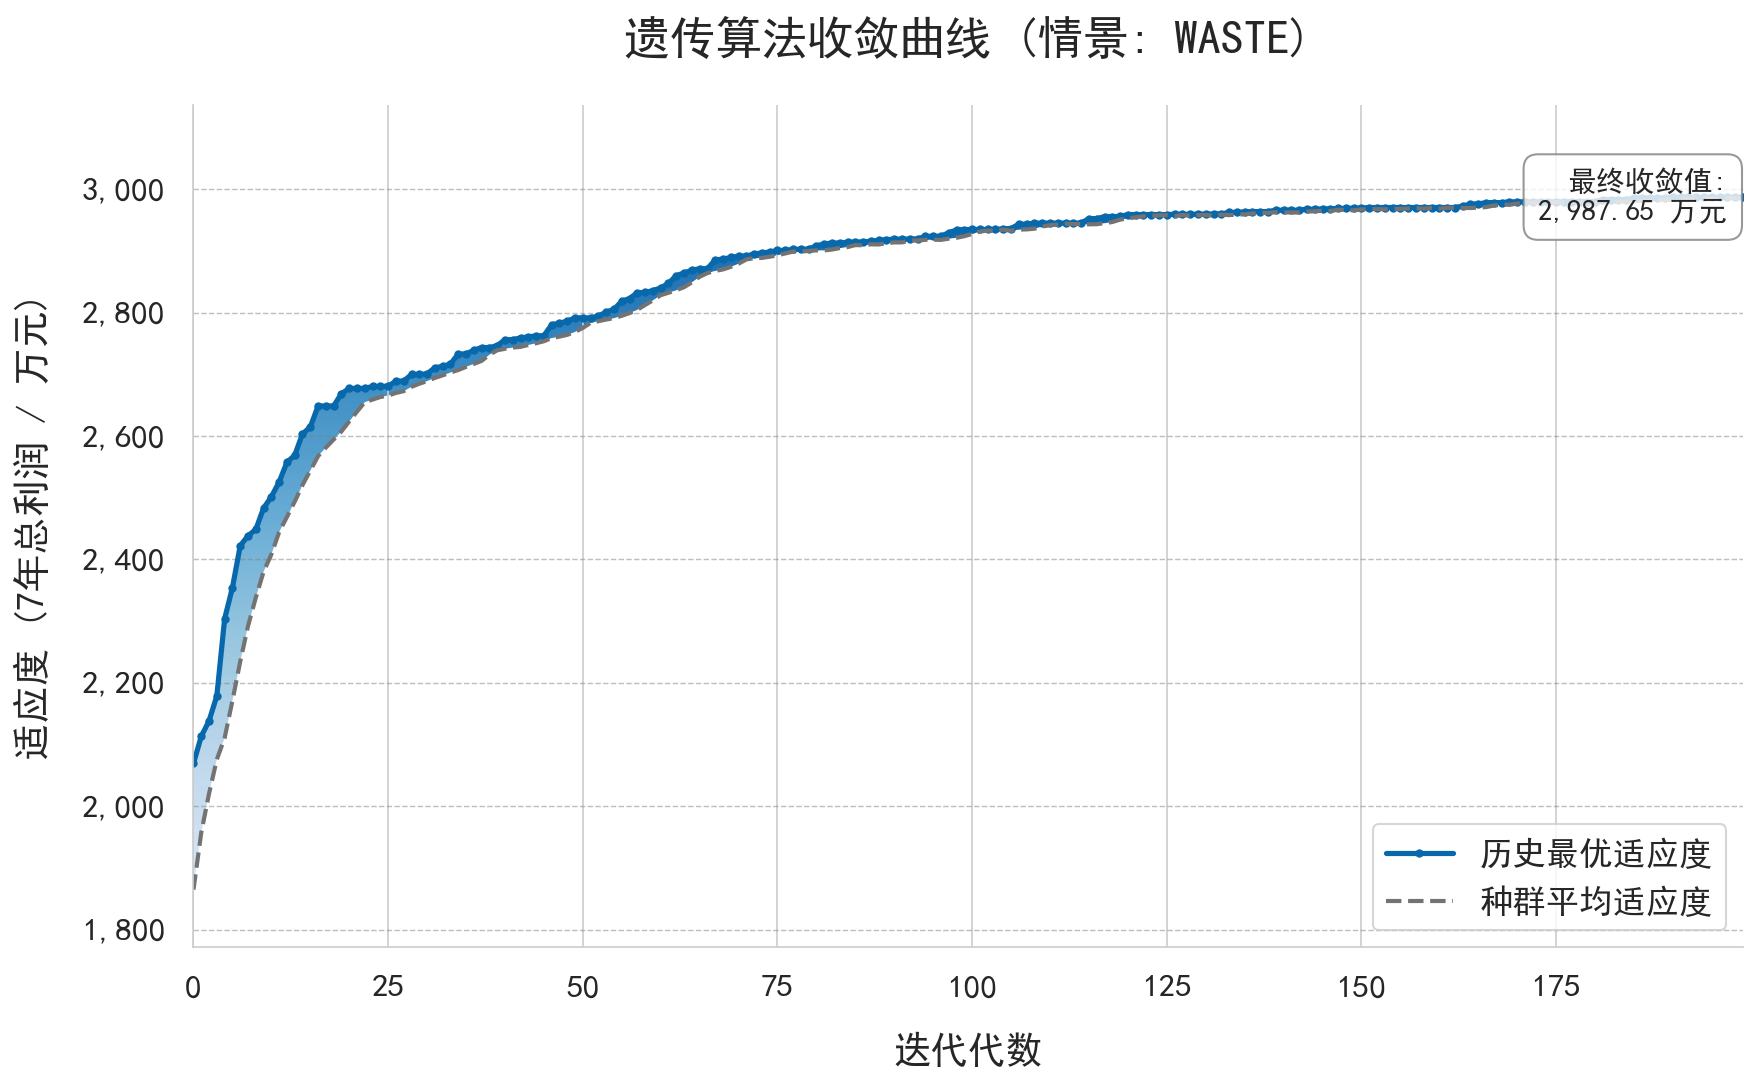


--- 正在生成情景 'discount' 的收敛曲线 ---
收敛曲线图已成功保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\convergence_discount.png


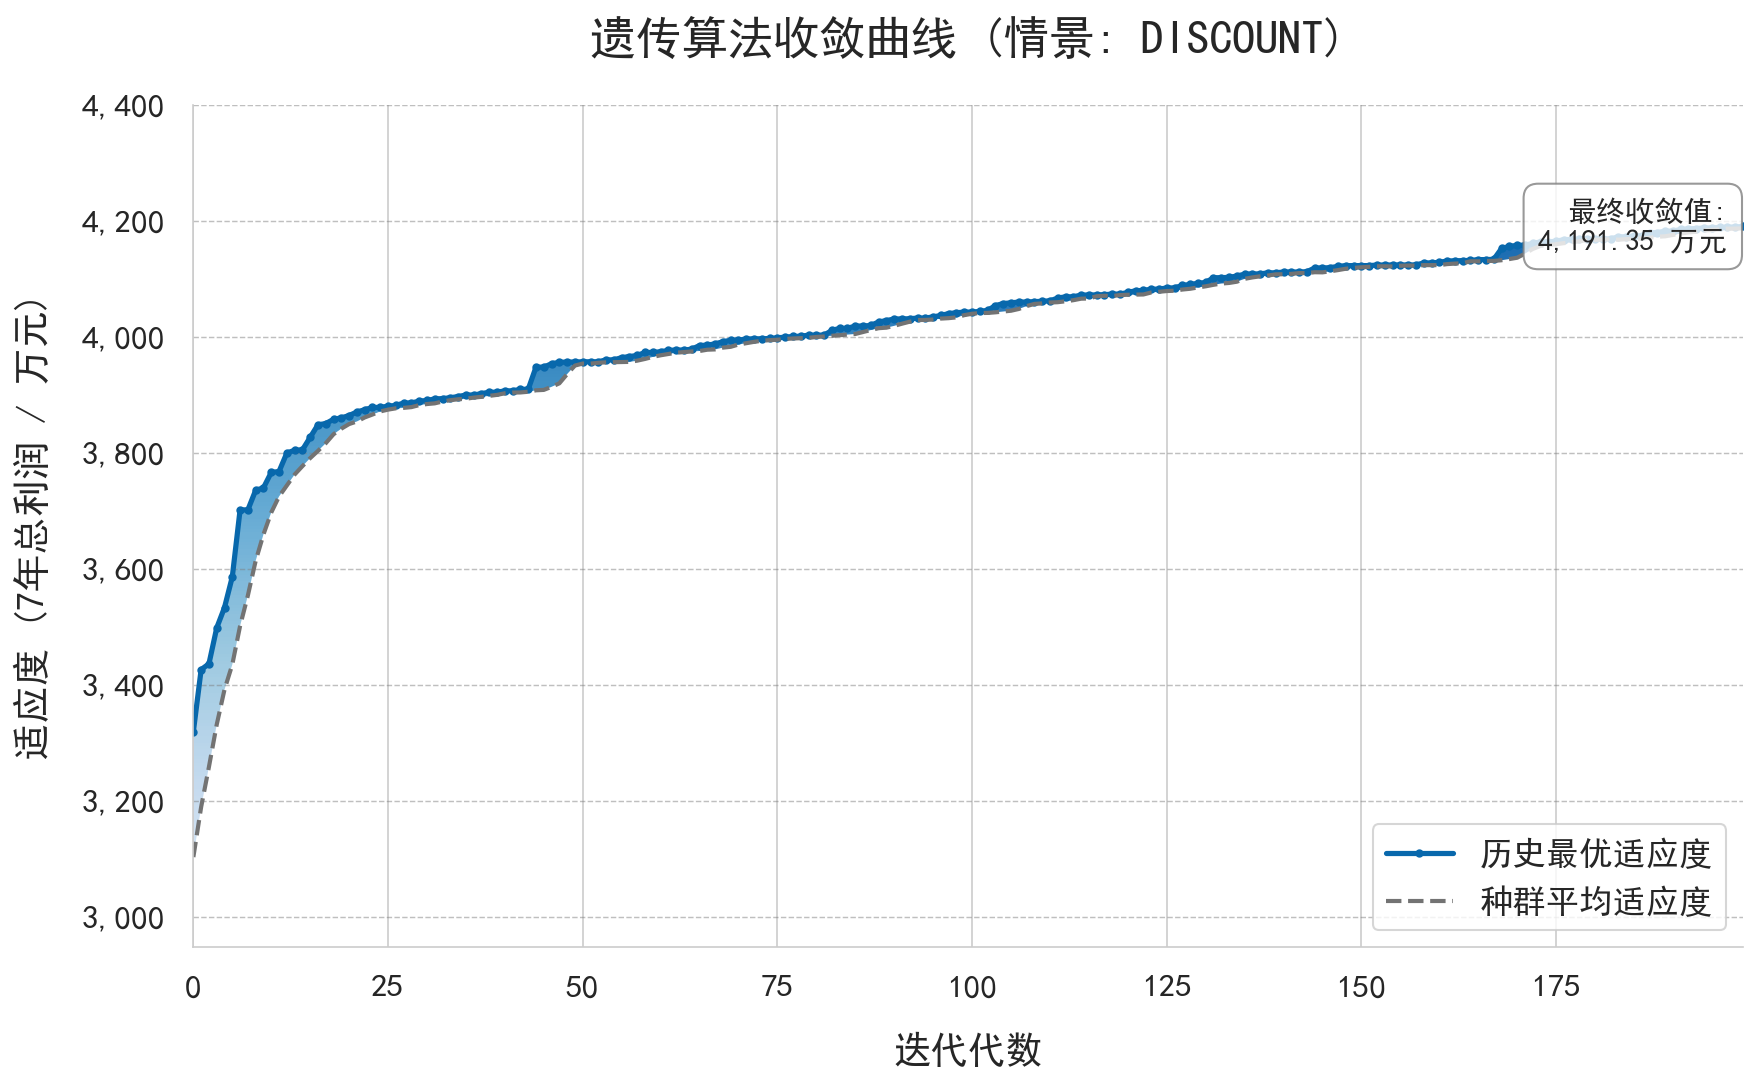

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib.transforms import TransformedPath
from matplotlib.ticker import FuncFormatter

def plot_convergence_final_style(log_path, output_path, scenario):
    """
    绘制最终风格的遗传算法收敛曲线图。
    """
    # --- 1. 设置字体与全局样式 ---
    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.size'] = 16

    try:
        df = pd.read_csv(log_path)
    except FileNotFoundError:
        print(f"警告: 日志文件 {log_path} 未找到，无法绘图。")
        return

    # --- 2. 绘制收敛曲线图 ---
    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=150)

    # 绘制曲线
    color_best = '#0868ac' # 专业蓝
    color_avg = '#737373'  # 中性灰
    ax.plot(df['Generation'], df['Best_Fitness'], color=color_best, linewidth=2.5, marker='o', markersize=3, label='历史最优适应度')
    ax.plot(df['Generation'], df['Average_Fitness'], color=color_avg, linewidth=2.0, linestyle='--', label='种群平均适应度')

    # --- 3. 实现上下渐变色填充 ---
    cmap = plt.get_cmap('Blues') 
    gradient_fill_colors = cmap(np.linspace(0.1, 0.9, 256))
    gradient_fill_cmap = plt.matplotlib.colors.ListedColormap(gradient_fill_colors)

    # 使用imshow创建渐变背景，并用曲线区域进行裁剪
    z = np.linspace(0, 1, 256).reshape(256, 1)
    y_min, y_max = ax.get_ylim()
    # 扩展y轴范围以确保渐变完全覆盖
    ax.set_ylim(bottom=df['Average_Fitness'].min() * 0.95, top=df['Best_Fitness'].max() * 1.05)
    y_min, y_max = ax.get_ylim()

    im = ax.imshow(z, aspect='auto', origin='lower', extent=[df['Generation'].min(), df['Generation'].max(), y_min, y_max], cmap=gradient_fill_cmap, zorder=0)

    path_data = np.array([
        df['Generation'].tolist() + df['Generation'].tolist()[::-1], 
        df['Average_Fitness'].tolist() + df['Best_Fitness'].tolist()[::-1]
    ]).transpose()
    path = plt.matplotlib.path.Path(path_data)
    clip_path = TransformedPath(path, ax.transData)
    im.set_clip_path(clip_path)

    # --- 4. 格式化与美化 ---
    ax.set_title(f'遗传算法收敛曲线 (情景: {scenario.upper()})', fontsize=22, pad=25, weight='bold')
    ax.set_xlabel('迭代代数', fontsize=18, labelpad=15)
    ax.set_ylabel('适应度 (7年总利润 / 万元)', fontsize=18, labelpad=15)

    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, color='grey', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    ax.legend(loc='lower right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
    
    # 格式化Y轴为“万元”
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y/1e4:,.0f}'))

    # 在曲线末端添加最终值注释
    final_value = df['Best_Fitness'].iloc[-1]
    ax.text(df['Generation'].iloc[-1] - 2, final_value, f'最终收敛值:\n{final_value/1e4:,.2f} 万元',
            ha='right', va='center', fontsize=14,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=1, alpha=0.8))

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    print(f"收敛曲线图已成功保存至: {output_path}")
    plt.show()


if __name__ == '__main__':
    current_dir = Path.cwd()
    output_dir = current_dir / '..' / 'Result'

    # 定义文件路径
    log_path_waste = output_dir / 'ga_log_waste.csv'
    plot_path_waste = output_dir / 'convergence_waste.png'
    log_path_discount = output_dir / 'ga_log_discount.csv'
    plot_path_discount = output_dir / 'convergence_discount.png'

    # 分别调用绘图函数
    print("--- 正在生成情景 'waste' 的收敛曲线 ---")
    plot_convergence_final_style(log_path_waste, plot_path_waste, 'waste')

    print("\n--- 正在生成情景 'discount' 的收敛曲线 ---")
    plot_convergence_final_style(log_path_discount, plot_path_discount, 'discount')

（1）正在读取Excel文件...
 -> 数据参数准备完成。

正在对参数 p 进行灵敏度分析...


测试不同的p值:  25%|██▌       | 1/4 [01:05<03:16, 65.60s/it]

p = 1 时，最优利润 = 4,888,140.88 元


测试不同的p值:  50%|█████     | 2/4 [02:17<02:18, 69.44s/it]

p = 2 时，最优利润 = 42,876,491.62 元


测试不同的p值:  75%|███████▌  | 3/4 [04:11<01:29, 89.72s/it]

p = 3 时，最优利润 = 42,972,886.62 元


测试不同的p值: 100%|██████████| 4/4 [06:12<00:00, 93.06s/it] 


p = 4 时，最优利润 = 42,367,421.25 元

正在对参数 q 进行灵敏度分析...


测试不同的q值:  25%|██▌       | 1/4 [01:46<05:18, 106.04s/it]

q = 2 时，最优利润 = 42,084,435.00 元


测试不同的q值:  50%|█████     | 2/4 [03:32<03:32, 106.38s/it]

q = 3 时，最优利润 = 42,532,157.88 元


测试不同的q值:  75%|███████▌  | 3/4 [04:56<01:36, 96.24s/it] 

q = 4 时，最优利润 = 43,034,533.12 元


测试不同的q值: 100%|██████████| 4/4 [06:15<00:00, 93.91s/it]

q = 5 时，最优利润 = 42,865,075.75 元



灵敏度分析图像已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\sensitivity_p_q.png


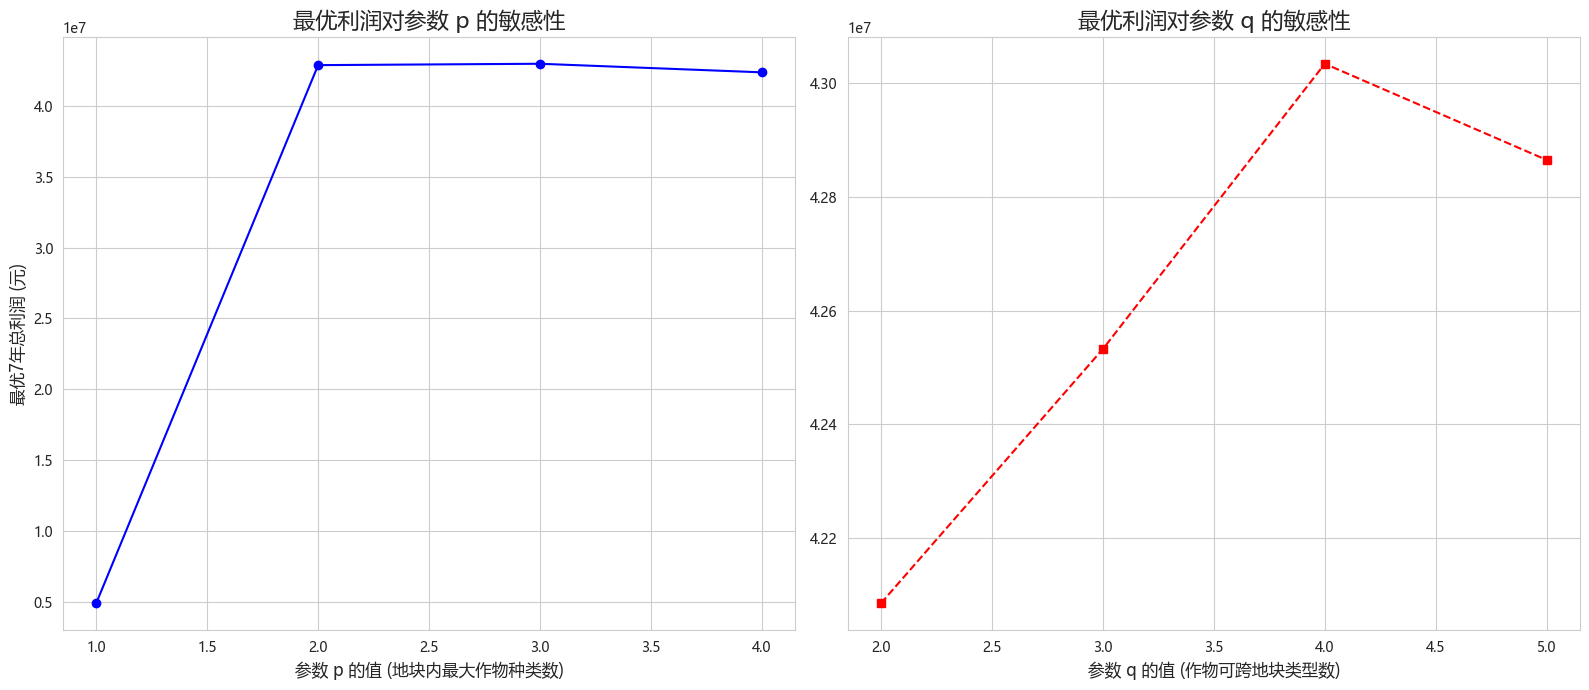


所有分析任务完成！


In [37]:
# -*- coding: utf-8 -*-
# 文件名: final_sensitivity_analysis.py
# 功能: 基于修复式遗传算法，对参数p和q进行灵敏度分析
# 版本: Final_Corrected

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 分析与算法配置区 ---
# 灵敏度分析参数范围
P_VALUES_TO_TEST = [1, 2, 3, 4]
Q_VALUES_TO_TEST = [2, 3, 4, 5]
DEFAULT_P = 2
DEFAULT_Q = 3

# GA参数
POP_SIZE = 100
MAX_GEN = 200 # 为确保收敛，建议使用稍大的代数
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# [修正] 惩罚权重 (只惩罚p和q，因为其他约束已被修复)
MAX_PROFIT_PER_ACRE = 300000 
W_DIVERSITY_P = MAX_PROFIT_PER_ACRE * 2
W_DIVERSITY_Q = MAX_PROFIT_PER_ACRE * 2

# --- 2. 核心功能函数 ---

def load_and_prepare_data(data_path):
    # (此函数内容与上一版完全相同)
    try:
        print("（1）正在读取Excel文件...")
        path_f1 = os.path.join(data_path, '附件1.xlsx'); path_f2 = os.path.join(data_path, '附件2.xlsx')
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地'); crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据'); past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
        for df in [plots_df, crops_info_df, stats_df, past_planting_df]: df.columns = df.columns.str.strip()
        params = {}; params['I_plots'] = sorted(plots_df['地块名称'].tolist()); params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩'])); params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型'])); bean_keywords = ['豆', '豆类']; params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop = row['种植地块'], row['作物名称']; season = row.get('种植季节', 1) 
            if plot in params['I_plots']: params['P_past'][plot][season] = crop
        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip());
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')
        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price); stats_df['亩产量/斤'] = pd.to_numeric(stats_df['亩产量/斤'], errors='coerce'); stats_df['种植成本/(元/亩)'] = pd.to_numeric(stats_df['种植成本/(元/亩)'], errors='coerce')
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        params['P_yield'], params['P_cost'], params['P_price'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型']); params['P_cost'][key] = row['种植成本/(元/亩)']; params['P_yield'][key] = row['亩产量/斤']; params['P_price'][key] = row['销售单价/(元/斤)']
        for crop in params['J_crops']:
            for plot_type in plots_df['地块类型'].unique():
                key = (crop, plot_type)
                if key not in params['P_yield']: params['P_yield'][key], params['P_cost'][key], params['P_price'][key] = 0, 9e9, 0
        params['P_demand'] = {j: 0 for j in params['J_crops']}
        temp_details = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称')
        for j in params['J_crops']:
            total_yield = sum(params['P_yield'].get((j, row['地块类型']), 0) * row.get('种植面积/亩', params['P_area'][row['地块名称']]) for _, row in temp_details[temp_details['作物名称'] == j].iterrows())
            params['P_demand'][j] = total_yield if total_yield > 0 else 1000
        params['S_suitability'] = {}; restricted_veg = ['大白菜', '白萝卜', '红萝卜']
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                crop_t = params['P_crop_type'].get(j, ''); is_veg = '蔬菜' in str(crop_t)
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        if '水稻' in j:
                            if k == 1: suitable = 1
                        elif is_veg:
                            if j not in restricted_veg and k == 1: suitable = 1
                            elif j in restricted_veg and k == 2: suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and j not in restricted_veg and k == 1: suitable = 1
                        elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        print(" -> 数据参数准备完成。")
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

class GeneticAlgorithm:
    def __init__(self, params, scenario):
        self.params = params
        self.scenario = scenario
        self.years = list(range(2024, 2031))

    def create_initial_solution(self):
        solution = {y: {k: {i: None for i in self.params['I_plots']} for k in [1, 2]} for y in self.years}
        for y in self.years:
            for i in self.params['I_plots']:
                for k in [1, 2]:
                    possible_crops = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9]
                    if possible_crops:
                        solution[y][k][i] = random.choice(possible_crops)
        return self.repair_solution(solution)

    def repair_solution(self, solution):
        # (修复函数逻辑，与之前成功的版本相同)
        def get_crops_in_year(sol, y, i):
            crops = set()
            if y == 2023:
                for k in [1, 2]:
                    crop = self.params['P_past'].get(i, {}).get(k)
                    if crop: crops.add(crop)
            elif y in sol:
                for k in [1, 2]:
                    crop = sol.get(y, {}).get(k, {}).get(i)
                    if crop: crops.add(crop)
            return list(crops)
        for i in self.params['I_plots']:
            for y in self.years:
                crops_this_year = get_crops_in_year(solution, y, i); crops_last_year = get_crops_in_year(solution, y - 1, i)
                common_crops = set(crops_this_year) & set(crops_last_year)
                if common_crops:
                    for k in [1, 2]:
                        if solution[y][k][i] in common_crops:
                            possible_replacements = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9 and j not in crops_last_year]
                            solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
        for i in self.params['I_plots']:
            if self.params['P_plot_type'].get(i) not in ['平旱地', '梯田', '山坡地', '水浇地']: continue
            all_years_sorted = [2023] + self.years
            for y_start_idx in range(len(all_years_sorted) - 2):
                window = all_years_sorted[y_start_idx : y_start_idx + 3]
                contains_bean = any(c in self.params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
                if not contains_bean:
                    for _ in range(5):
                        y_fix = random.choice([y for y in window if y > 2023]); k_fix = 1
                        crops_last_year_for_fix = get_crops_in_year(solution, y_fix - 1, i)
                        possible_beans = [b for b in self.params['J_bean'] if self.params['S_suitability'].get((i, b, k_fix), 0) == 1 and self.params['P_cost'].get((b, self.params['P_plot_type'][i]), 9e9) < 1e9 and b not in crops_last_year_for_fix]
                        if possible_beans: solution[y_fix][k_fix][i] = random.choice(possible_beans); break
        return solution

    def evaluate_fitness(self, solution):
        # 确定性利润计算
        total_revenue, total_cost = 0, 0
        total_production = defaultdict(float)
        for y in self.years:
            for i in self.params['I_plots']:
                plot_type = self.params['P_plot_type'][i]; area = self.params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k][i]
                    if not crop: continue
                    key = (crop, plot_type); cost = self.params['P_cost'].get(key, 0); yield_val = self.params['P_yield'].get(key, 0)
                    total_cost += area * cost; total_production[crop] += area * yield_val
        for crop, production in total_production.items():
            total_demand = self.params['P_demand'].get(crop, 0) * 7
            price = next((p for (c, pt), p in self.params['P_price'].items() if c == crop), 0)
            if self.scenario == 'waste':
                sold_qty = min(production, total_demand); total_revenue += sold_qty * price
            elif self.scenario == 'discount':
                normal_qty = min(production, total_demand); over_qty = production - normal_qty
                total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        total_profit = total_revenue - total_cost

        # [新增] 只对p和q进行惩罚
        violations = defaultdict(int)
        for y in self.years:
            # p 约束
            for i in self.params['I_plots']:
                crops_in_plot_seasons = {solution[y][k][i] for k in [1, 2] if solution[y][k][i]}
                if len(crops_in_plot_seasons) > self.params['p_limit']:
                    violations['p'] += (len(crops_in_plot_seasons) - self.params['p_limit'])
            # q 约束
            for k in [1, 2]:
                types_per_crop = defaultdict(set)
                for i in self.params['I_plots']:
                    crop = solution[y][k][i]
                    if crop: types_per_crop[crop].add(self.params['P_plot_type'][i])
                for crop, types in types_per_crop.items():
                    if len(types) > self.params['q_limit']:
                        violations['q'] += (len(types) - self.params['q_limit'])
        
        total_penalty = violations['p'] * W_DIVERSITY_P + violations['q'] * W_DIVERSITY_Q
        return total_profit - total_penalty

    def run(self):
        population = [self.create_initial_solution() for _ in range(POP_SIZE)]
        best_fitness = -np.inf
        for gen in range(MAX_GEN): # tqdm can be added here if needed
            fitnesses = [self.evaluate_fitness(sol) for sol in population]
            best_fit_gen = np.max(fitnesses)
            if best_fit_gen > best_fitness:
                best_fitness = best_fit_gen
            
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
            new_population = [population[i] for i in elite_indices]
            while len(new_population) < POP_SIZE:
                def tournament_selection(pop, fits, k):
                    best_idx = random.randrange(len(pop));
                    for _ in range(k-1): idx=random.randrange(len(pop)); best_idx = idx if fits[idx]>fits[best_idx] else best_idx
                    return pop[best_idx]
                p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                child = crossover(p1, p2, self.params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB:
                    child = mutate(child, self.params)
                new_population.append(self.repair_solution(child))
            population = new_population
        return best_fitness

def plot_sensitivity_curves(p_results, q_results, output_dir):
    # (绘图函数与上一版完全相同)
    sns.set_style("whitegrid"); plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']; plt.rcParams['axes.unicode_minus'] = False
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    p_df = pd.DataFrame(p_results); ax1.plot(p_df['value'], p_df['profit'], marker='o', linestyle='-', color='b')
    ax1.set_title('最优利润对参数 p 的敏感性', fontsize=16); ax1.set_xlabel('参数 p 的值 (地块内最大作物种类数)', fontsize=12); ax1.set_ylabel('最优7年总利润 (元)', fontsize=12)
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    q_df = pd.DataFrame(q_results); ax2.plot(q_df['value'], q_df['profit'], marker='s', linestyle='--', color='r')
    ax2.set_title('最优利润对参数 q 的敏感性', fontsize=16); ax2.set_xlabel('参数 q 的值 (作物可跨地块类型数)', fontsize=12)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout(); output_path = os.path.join(output_dir, "sensitivity_p_q.png")
    plt.savefig(output_path, dpi=300); print(f"\n灵敏度分析图像已保存至: {output_path}"); plt.show()

# --- 4. 主程序 ---
if __name__ == '__main__':
    try:
        current_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
        data_path = current_dir / '..' / 'Data'
        output_dir = current_dir / '..' / 'Result'
        output_dir.mkdir(parents=True, exist_ok=True)

        params = load_and_prepare_data(data_path)
        if not params: raise RuntimeError("数据加载失败。")

        # --- 对 p 进行灵敏度分析 ---
        print("\n" + "="*50 + "\n正在对参数 p 进行灵敏度分析...\n" + "="*50)
        p_results = []
        params['q_limit'] = DEFAULT_Q
        for p_val in tqdm(P_VALUES_TO_TEST, desc="测试不同的p值"):
            params['p_limit'] = p_val
            ga_solver = GeneticAlgorithm(params, 'discount')
            best_profit = ga_solver.run()
            p_results.append({'value': p_val, 'profit': best_profit})
            print(f"p = {p_val} 时，最优利润 = {best_profit:,.2f} 元")

        # --- 对 q 进行灵敏度分析 ---
        print("\n" + "="*50 + "\n正在对参数 q 进行灵敏度分析...\n" + "="*50)
        q_results = []
        params['p_limit'] = DEFAULT_P
        for q_val in tqdm(Q_VALUES_TO_TEST, desc="测试不同的q值"):
            params['q_limit'] = q_val
            ga_solver = GeneticAlgorithm(params, 'discount')
            best_profit = ga_solver.run()
            q_results.append({'value': q_val, 'profit': best_profit})
            print(f"q = {q_val} 时，最优利润 = {best_profit:,.2f} 元")

        # --- 绘制结果 ---
        plot_sensitivity_curves(p_results, q_results, output_dir)

        print("\n所有分析任务完成！")
    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()

 -> 数据参数准备完成。

正在对土地面积进行灵敏度分析...

--- 计算基准情景 (100% 面积)... ---
基准情景最优利润 = 41,502,755.12 元


分析地块类型: 水浇地: 100%|██████████| 5/5 [02:44<00:00, 32.86s/it]



面积灵敏度分析图像已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\sensitivity_area.png


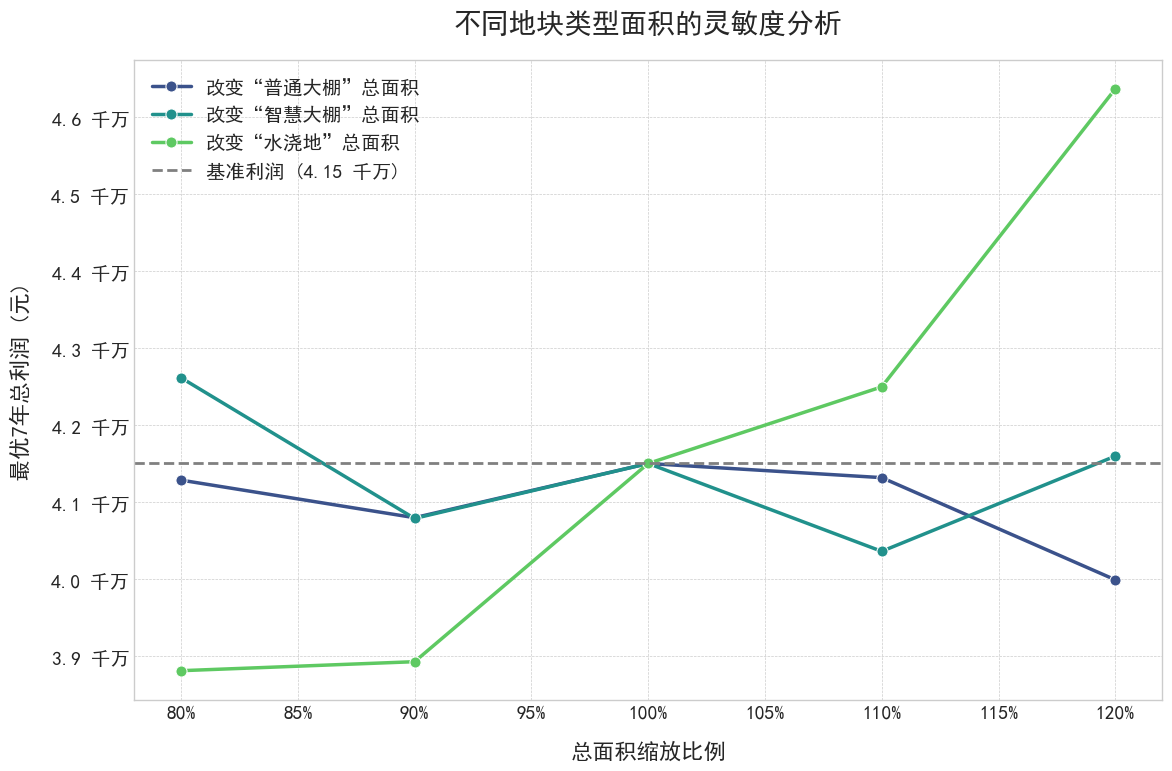


所有分析任务完成！
--- 正在生成情景 'waste' 的收敛曲线 ---
收敛曲线图已成功保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\convergence_waste.png


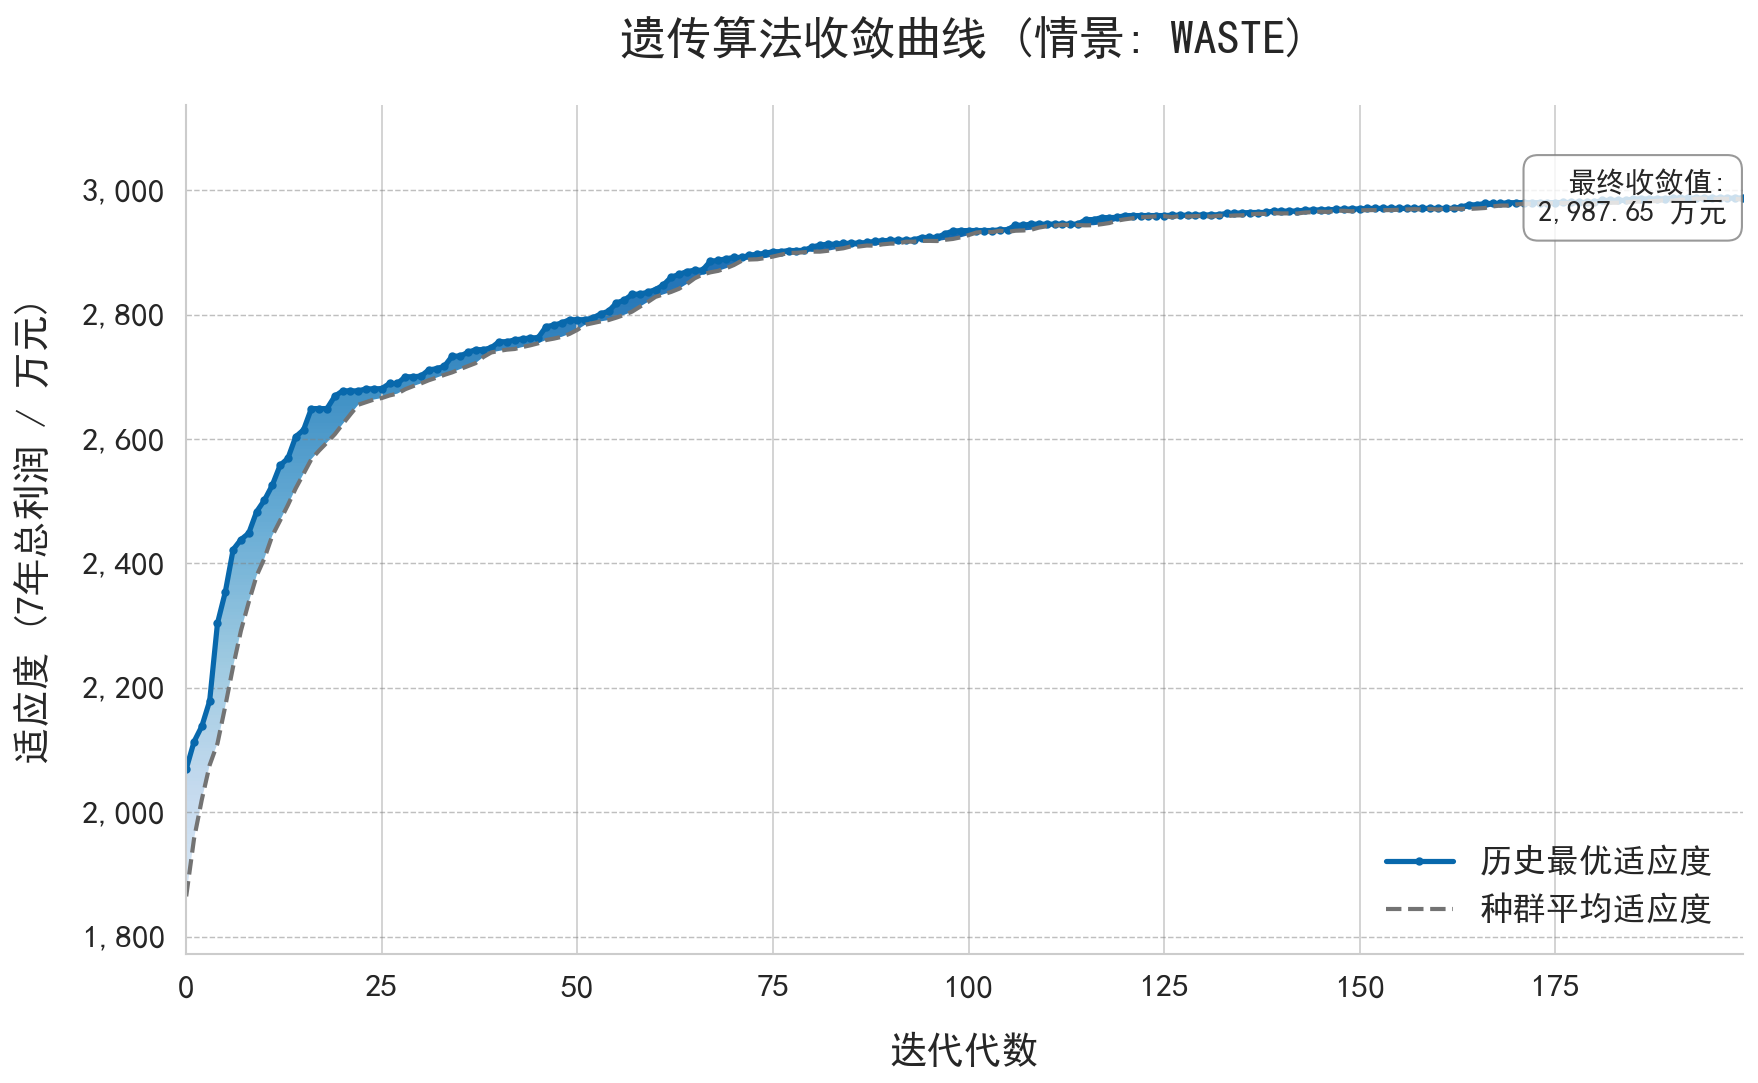


--- 正在生成情景 'discount' 的收敛曲线 ---
收敛曲线图已成功保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\convergence_discount.png


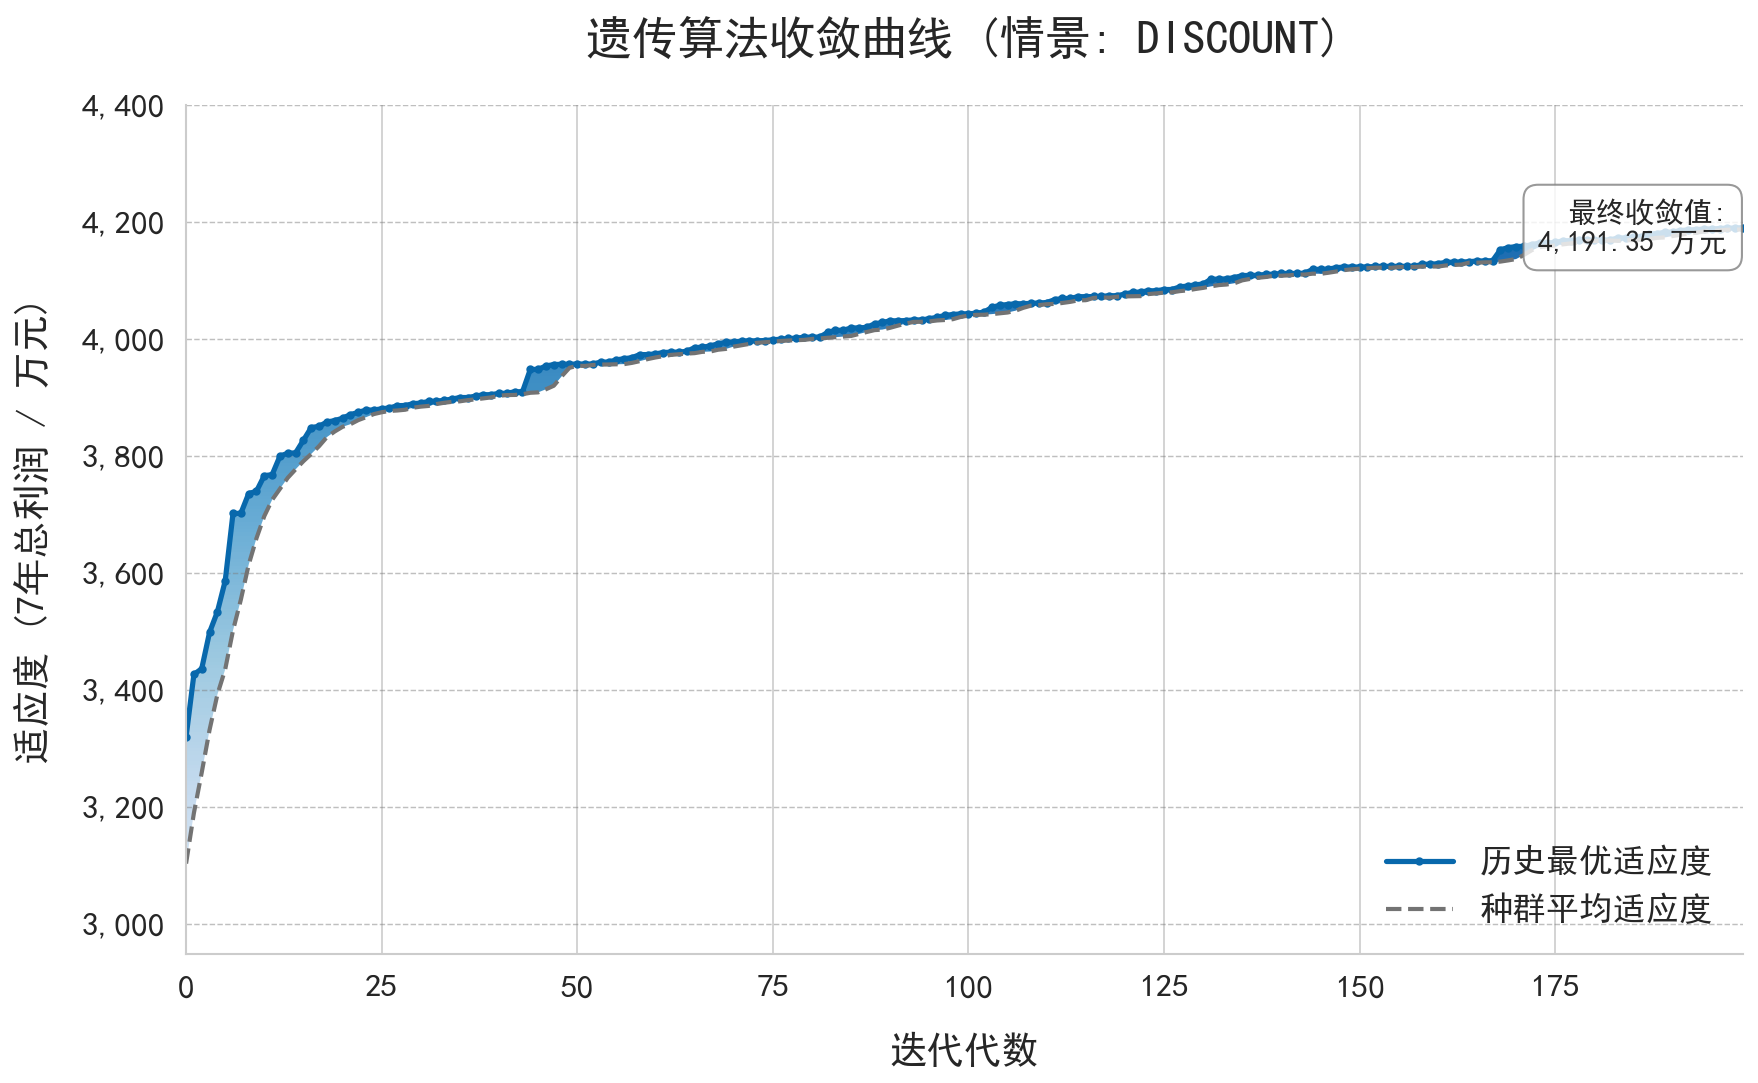

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib.transforms import TransformedPath
from matplotlib.ticker import FuncFormatter

def plot_convergence_final_style(log_path, output_path, scenario):
    """
    绘制最终风格的遗传算法收敛曲线图。
    """
    # --- 1. 设置字体与全局样式 ---
    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.size'] = 16

    try:
        df = pd.read_csv(log_path)
    except FileNotFoundError:
        print(f"警告: 日志文件 {log_path} 未找到，无法绘图。")
        return

    # --- 2. 绘制收敛曲线图 ---
    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=150)

    # 绘制曲线
    color_best = '#0868ac' # 专业蓝
    color_avg = '#737373'  # 中性灰
    ax.plot(df['Generation'], df['Best_Fitness'], color=color_best, linewidth=2.5, marker='o', markersize=3, label='历史最优适应度')
    ax.plot(df['Generation'], df['Average_Fitness'], color=color_avg, linewidth=2.0, linestyle='--', label='种群平均适应度')

    # --- 3. 实现上下渐变色填充 ---
    cmap = plt.get_cmap('Blues') 
    gradient_fill_colors = cmap(np.linspace(0.1, 0.9, 256))
    gradient_fill_cmap = plt.matplotlib.colors.ListedColormap(gradient_fill_colors)

    # 使用imshow创建渐变背景，并用曲线区域进行裁剪
    z = np.linspace(0, 1, 256).reshape(256, 1)
    y_min, y_max = ax.get_ylim()
    # 扩展y轴范围以确保渐变完全覆盖
    ax.set_ylim(bottom=df['Average_Fitness'].min() * 0.95, top=df['Best_Fitness'].max() * 1.05)
    y_min, y_max = ax.get_ylim()

    im = ax.imshow(z, aspect='auto', origin='lower', extent=[df['Generation'].min(), df['Generation'].max(), y_min, y_max], cmap=gradient_fill_cmap, zorder=0)

    path_data = np.array([
        df['Generation'].tolist() + df['Generation'].tolist()[::-1], 
        df['Average_Fitness'].tolist() + df['Best_Fitness'].tolist()[::-1]
    ]).transpose()
    path = plt.matplotlib.path.Path(path_data)
    clip_path = TransformedPath(path, ax.transData)
    im.set_clip_path(clip_path)

    # --- 4. 格式化与美化 ---
    ax.set_title(f'遗传算法收敛曲线 (情景: {scenario.upper()})', fontsize=22, pad=25, weight='bold')
    ax.set_xlabel('迭代代数', fontsize=18, labelpad=15)
    ax.set_ylabel('适应度 (7年总利润 / 万元)', fontsize=18, labelpad=15)

    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, color='grey', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    ax.legend(loc='lower right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
    
    # 格式化Y轴为“万元”
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y/1e4:,.0f}'))

    # 在曲线末端添加最终值注释
    final_value = df['Best_Fitness'].iloc[-1]
    ax.text(df['Generation'].iloc[-1] - 2, final_value, f'最终收敛值:\n{final_value/1e4:,.2f} 万元',
            ha='right', va='center', fontsize=14,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=1, alpha=0.8))

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    print(f"收敛曲线图已成功保存至: {output_path}")
    plt.show()


if __name__ == '__main__':
    current_dir = Path.cwd()
    output_dir = current_dir / '..' / 'Result'

    # 定义文件路径
    log_path_waste = output_dir / 'ga_log_waste.csv'
    plot_path_waste = output_dir / 'convergence_waste.png'
    log_path_discount = output_dir / 'ga_log_discount.csv'
    plot_path_discount = output_dir / 'convergence_discount.png'

    # 分别调用绘图函数# -*- coding: utf-8 -*-
# 文件名: run_sensitivity_analysis_area.py
# 功能: 对不同地块类型的总面积进行灵敏度分析

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# --- 1. 分析与算法配置区 ---

# [新增] 面积灵敏度分析参数
# 选择要分析的地块类型 (注意名称必须与Excel中完全一致)
LAND_TYPES_TO_ANALYZE = ['普通大棚', '智慧大棚', '水浇地'] 
# 面积缩放系数范围
AREA_SCALING_FACTORS = [0.8, 0.9, 1.0, 1.1, 1.2] 

# GA参数 (为节省时间，可以适当减少代数)
POP_SIZE = 80
MAX_GEN = 150 
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# --- 2. 核心功能函数 (与之前版本相同) ---

def load_and_prepare_data(data_path):
    # (此函数内容与上一版完全相同，为简洁此处折叠)
    try:
        path_f1 = os.path.join(data_path, '附件1.xlsx'); path_f2 = os.path.join(data_path, '附件2.xlsx')
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地'); crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据'); past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
    except Exception as e: print(f"错误: 读取Excel文件失败。具体错误: {e}"); return None
    for df in [plots_df, crops_info_df, stats_df, past_planting_df]: df.columns = df.columns.str.strip()
    params = {}
    params['I_plots'] = sorted(plots_df['地块名称'].tolist()); params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
    params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩'])); params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
    params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型'])); bean_keywords = ['豆', '豆类']; params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
    params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
    for _, row in past_planting_df.iterrows():
        plot, crop = row['种植地块'], row['作物名称']; season = row.get('种植季节', 1) 
        if plot in params['I_plots']: params['P_past'][plot][season] = crop
    def clean_and_convert_price(value):
        if isinstance(value, str) and any(c in value for c in '-–—'):
            parts = re.split(r'[-–—]', value.strip());
            try: return (float(parts[0]) + float(parts[1])) / 2
            except (ValueError, IndexError): return np.nan
        return pd.to_numeric(value, errors='coerce')
    stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price); stats_df['亩产量/斤'] = pd.to_numeric(stats_df['亩产量/斤'], errors='coerce'); stats_df['种植成本/(元/亩)'] = pd.to_numeric(stats_df['种植成本/(元/亩)'], errors='coerce')
    stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
    params['P_yield'], params['P_cost'], params['P_price'] = {}, {}, {}
    for _, row in stats_df.iterrows():
        key = (row['作物名称'], row['地块类型']); params['P_cost'][key] = row['种植成本/(元/亩)']; params['P_yield'][key] = row['亩产量/斤']; params['P_price'][key] = row['销售单价/(元/斤)']
    for crop in params['J_crops']:
        for plot_type in plots_df['地块类型'].unique():
            key = (crop, plot_type)
            if key not in params['P_yield']: params['P_yield'][key], params['P_cost'][key], params['P_price'][key] = 0, 9e9, 0
    params['P_demand'] = {j: 0 for j in params['J_crops']}
    temp_details = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称')
    for j in params['J_crops']:
        total_yield = sum(params['P_yield'].get((j, row['地块类型']), 0) * row.get('种植面积/亩', params['P_area'][row['地块名称']]) for _, row in temp_details[temp_details['作物名称'] == j].iterrows())
        params['P_demand'][j] = total_yield if total_yield > 0 else 1000
    params['S_suitability'] = {}; restricted_veg = ['大白菜', '白萝卜', '红萝卜']
    for i in params['I_plots']:
        plot_t = params['P_plot_type'].get(i, '')
        for j in params['J_crops']:
            crop_t = params['P_crop_type'].get(j, ''); is_veg = '蔬菜' in str(crop_t)
            for k in [1, 2]:
                suitable = 0
                if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                elif plot_t == '水浇地':
                    if '水稻' in j:
                        if k == 1: suitable = 1
                    elif is_veg:
                        if j not in restricted_veg and k == 1: suitable = 1
                        elif j in restricted_veg and k == 2: suitable = 1
                elif plot_t == '普通大棚':
                    if is_veg and j not in restricted_veg and k == 1: suitable = 1
                    elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                params['S_suitability'][(i, j, k)] = suitable
    print(" -> 数据参数准备完成。")
    return params

class GeneticAlgorithm:
    # (整个类的代码与上一版修复式GA完全相同，为简洁此处折叠)
    def __init__(self, params, scenario):
        self.params = params; self.scenario = scenario; self.years = list(range(2024, 2031))
    def create_initial_solution(self):
        solution = {y: {k: {i: None for i in self.params['I_plots']} for k in [1, 2]} for y in self.years}
        for y in self.years:
            for i in self.params['I_plots']:
                for k in [1, 2]:
                    possible_crops = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9]
                    if possible_crops: solution[y][k][i] = random.choice(possible_crops)
        return self.repair_solution(solution)
    def repair_solution(self, solution):
        def get_crops_in_year(sol, y, i):
            crops = set()
            if y == 2023:
                for k in [1, 2]:
                    crop = self.params['P_past'].get(i, {}).get(k)
                    if crop: crops.add(crop)
            elif y in sol:
                for k in [1, 2]:
                    crop = sol.get(y, {}).get(k, {}).get(i)
                    if crop: crops.add(crop)
            return list(crops)
        for i in self.params['I_plots']:
            for y in self.years:
                crops_this_year = get_crops_in_year(solution, y, i); crops_last_year = get_crops_in_year(solution, y - 1, i)
                common_crops = set(crops_this_year) & set(crops_last_year)
                if common_crops:
                    for k in [1, 2]:
                        if solution[y][k][i] in common_crops:
                            possible_replacements = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9 and j not in crops_last_year]
                            solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
        for i in self.params['I_plots']:
            if self.params['P_plot_type'].get(i) not in ['平旱地', '梯田', '山坡地', '水浇地']: continue
            all_years_sorted = [2023] + self.years
            for y_start_idx in range(len(all_years_sorted) - 2):
                window = all_years_sorted[y_start_idx : y_start_idx + 3]
                contains_bean = any(c in self.params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
                if not contains_bean:
                    for _ in range(5):
                        y_fix = random.choice([y for y in window if y > 2023]); k_fix = 1
                        crops_last_year_for_fix = get_crops_in_year(solution, y_fix - 1, i)
                        possible_beans = [b for b in self.params['J_bean'] if self.params['S_suitability'].get((i, b, k_fix), 0) == 1 and self.params['P_cost'].get((b, self.params['P_plot_type'][i]), 9e9) < 1e9 and b not in crops_last_year_for_fix]
                        if possible_beans: solution[y_fix][k_fix][i] = random.choice(possible_beans); break
        return solution
    def evaluate_fitness(self, solution):
        total_revenue, total_cost = 0, 0; total_production = defaultdict(float)
        for y in self.years:
            for i in self.params['I_plots']:
                plot_type = self.params['P_plot_type'][i]; area = self.params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k][i]
                    if not crop: continue
                    key = (crop, plot_type); cost = self.params['P_cost'].get(key, 0); yield_val = self.params['P_yield'].get(key, 0)
                    total_cost += area * cost; total_production[crop] += area * yield_val
        for crop, production in total_production.items():
            total_demand = self.params['P_demand'].get(crop, 0) * 7
            price = next((p for (c, pt), p in self.params['P_price'].items() if c == crop), 0)
            if self.scenario == 'waste': sold_qty = min(production, total_demand); total_revenue += sold_qty * price
            elif self.scenario == 'discount': normal_qty = min(production, total_demand); over_qty = production - normal_qty; total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        return total_revenue - total_cost
    def run(self):
        population = [self.create_initial_solution() for _ in range(POP_SIZE)]; best_fitness = -np.inf
        for gen in range(MAX_GEN):
            fitnesses = [self.evaluate_fitness(sol) for sol in population]; best_fit_gen = np.max(fitnesses)
            if best_fit_gen > best_fitness: best_fitness = best_fit_gen
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]; new_population = [population[i] for i in elite_indices]
            while len(new_population) < POP_SIZE:
                def tournament_selection(pop, fits, k):
                    best_idx = random.randrange(len(pop));
                    for _ in range(k-1): idx=random.randrange(len(pop)); best_idx = idx if fits[idx]>fits[best_idx] else best_idx
                    return pop[best_idx]
                p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE); p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                child = crossover(p1, p2, self.params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB: child = mutate(child, self.params)
                new_population.append(self.repair_solution(child))
            population = new_population
        return best_fitness

# --- 3. [新增] 绘图函数 ---
def plot_area_sensitivity(results, baseline_profit, output_dir):
    """
    绘制面积灵敏度分析的折线图
    """
    # 遵照您的要求，设置高级、非热门、符合学术风格的图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = ['SimHei'] # 确保中文显示
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 使用一个更沉稳、高级的调色板
    palette = sns.color_palette("viridis", n_colors=len(results))

    for i, (land_type, df) in enumerate(results.items()):
        sns.lineplot(data=df, x='scale', y='profit', label=f'改变“{land_type}”总面积', 
                     marker='o', markersize=8, linewidth=2.5, color=palette[i])

    # 添加基准线
    ax.axhline(y=baseline_profit, color='grey', linestyle='--', linewidth=2, label=f'基准利润 ({baseline_profit/1e7:,.2f} 千万)')

    # 美化图表
    ax.set_title('不同地块类型面积的灵敏度分析', fontsize=20, pad=20, weight='bold')
    ax.set_xlabel('总面积缩放比例', fontsize=16, labelpad=15)
    ax.set_ylabel('最优7年总利润 (元)', fontsize=16, labelpad=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # 格式化X轴和Y轴标签
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f'{y/1e7:,.1f} 千万'))
    
    ax.legend(fontsize=14, loc='best')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    output_path = os.path.join(output_dir, "sensitivity_area.png")
    plt.savefig(output_path, dpi=300)
    print(f"\n面积灵敏度分析图像已保存至: {output_path}")
    plt.show()

# --- 4. 主程序 ---
if __name__ == '__main__':
    try:
        current_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
        data_path = current_dir / '..' / 'Data'
        output_dir = current_dir / '..' / 'Result'
        output_dir.mkdir(parents=True, exist_ok=True)

        base_params = load_and_prepare_data(data_path)
        if not base_params: raise RuntimeError("数据加载失败。")

        # --- 灵敏度分析主循环 ---
        print("\n" + "="*50 + "\n正在对土地面积进行灵敏度分析...\n" + "="*50)
        
        # 运行一次基准情景
        print("\n--- 计算基准情景 (100% 面积)... ---")
        ga_solver_base = GeneticAlgorithm(base_params, 'discount')
        baseline_profit = ga_solver_base.run()
        print(f"基准情景最优利润 = {baseline_profit:,.2f} 元")

        analysis_results = {}
        
        # 循环遍历要分析的地块类型
        for land_type in LAND_TYPES_TO_ANALYZE:
            type_results_data = []
            
            # 循环遍历不同的缩放系数
            for scale in tqdm(AREA_SCALING_FACTORS, desc=f"分析地块类型: {land_type}"):
                
                # 如果是基准情况，直接使用已算出的结果
                if scale == 1.0:
                    type_results_data.append({'scale': 100, 'profit': baseline_profit})
                    continue

                # 创建临时参数副本进行修改
                temp_params = copy.deepcopy(base_params)
                
                # 修改对应地块类型的面积
                for plot_name, original_area in temp_params['P_area'].items():
                    if temp_params['P_plot_type'][plot_name] == land_type:
                        temp_params['P_area'][plot_name] = original_area * scale
                
                # 使用修改后的参数运行GA
                ga_solver = GeneticAlgorithm(temp_params, 'discount')
                best_profit = ga_solver.run()
                type_results_data.append({'scale': scale * 100, 'profit': best_profit})

            analysis_results[land_type] = pd.DataFrame(type_results_data)
        
        # --- 绘制结果 ---
        plot_area_sensitivity(analysis_results, baseline_profit, output_dir)

        print("\n所有分析任务完成！")

    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()
    print("--- 正在生成情景 'waste' 的收敛曲线 ---")
    plot_convergence_final_style(log_path_waste, plot_path_waste, 'waste')

    print("\n--- 正在生成情景 'discount' 的收敛曲线 ---")
    plot_convergence_final_style(log_path_discount, plot_path_discount, 'discount')